# Gravitation in PHANTOM
**Test of PHANTOM long-range interaction acceleration**

<!-- @article{PriceEtAl2018,
  title = {{$<$}scp{$>$}{{Phantom}}{$<$}/Scp{$>$}: {{A Smoothed Particle Hydrodynamics}} and {{Magnetohydrodynamics Code}} for {{Astrophysics}}},
  author = {Price, Daniel J. and Wurster, James and Tricco, Terrence S. and Nixon, Chris and Toupin, Stéven and Pettitt, Alex and Chan, Conrad and Mentiplay, Daniel and Laibe, Guillaume and Glover, Simon and Dobbs, Clare and Nealon, Rebecca and Liptai, David and Worpel, Hauke and Bonnerot, Clément and Dipierro, Giovanni and Ballabio, Giulia and Ragusa, Enrico and Federrath, Christoph and Iaconi, Roberto and Reichardt, Thomas and Forgan, Duncan and Hutchison, Mark and Constantino, Thomas and Ayliffe, Ben and Hirsh, Kieran and Lodato, Giuseppe},
  date = {2018},
  journaltitle = {Publications of the Astronomical Society of Australia},
  shortjournal = {Publ. Astron. Soc. Aust.},
  volume = {35},
  number = {2018},
  eprint = {1702.03930},
  eprinttype = {arxiv},
  pages = {e031},
  issn = {1323-3580},
  doi = {10.1017/pasa.2018.25},
  url = {https://www.cambridge.org/core/product/identifier/S1323358018000255/type/journal_article},
  abstract = {We present Phantom , a fast, parallel, modular, and low-memory smoothed particle hydrodynamics and magnetohydrodynamics code developed over the last decade for astrophysical applications in three dimensions. The code has been developed with a focus on stellar, galactic, planetary, and high energy astrophysics, and has already been used widely for studies of accretion discs and turbulence, from the birth of planets to how black holes accrete. Here we describe and test the core algorithms as well as modules for magnetohydrodynamics, self-gravity, sink particles, dust–gas mixtures, H 2 chemistry, physical viscosity, external forces including numerous galactic potentials, Lense–Thirring precession, Poynting–Robertson drag, and stochastic turbulent driving. Phantom is hereby made publicly available.},
  langid = {english},
  keywords = {★, accretion, accretion disks, gravitaion, hydrodynamics, SM: general, agnetohydrodynamics (MHD), methods: numerical, PHANTOM, SPH},
  annotation = {262 citations (Crossref) [2024-03-19]},
  file = {/Users/marat/Yandex.Disk.localized/Documents/Zotero/storage/UB8DW3WQ/Price et al - 2018 - scpPhantom-scp - A Smoothed Particle Hydrodynamics and Magnetohydrodynamics.pdf}
} -->

In [757]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];
ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",
    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]
<<TensorSimplify` *)

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 674 Kb


## Einstein Summation

In [765]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
      transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [773]:
(* different variants *)
(* Norm[dx]^2 *)
(* SquareLength[x_] := EinsteinSummation[{{i}, {i}}, {x, x}] *)
SquareLength[x_] := x.x

## Test of partice-node force

### Definitions of vectors

In [777]:
(* r is a distance between particle and node *)
(* M is a mass of the node *)
$Assumptions = {
  _ \[Element] Reals,
  {r, M} \[Element] PositiveReals
};

(* rv is the relative position vector *)
rv = Array[Subscript[r, ##] &, {3}];

(* corresponding unit vector *)
(* ur = Normalize[rv] *)
ur = rv/Sqrt[SquareLength[rv]];

(* unit vector rv with hat *)
(* h means hat *)
urh = Array[Subscript[OverHat[r], ##] &, {3}];

### Quadrupole moments

In [788]:
(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
(* https://mathematica.stackexchange.com/questions/127513/how-to-create-a-symmetric-symbolic-tensor *)
Qij = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[Q, {i, j}], {3, 3}, Symmetric[{1, 2}]];
(* SymmetricMatrixQ[Qij] *)

Qi = EinsteinSummation[{{j}, {i, j}}, {ur, Qij}];
Qih = EinsteinSummation[{{j}, {i, j}}, {urh, Qij}];

In [794]:
ClearAll@DoCollapse
DoCollapse[f_] :=
  Module[{func = f},
    Expand[
      ReplaceAll[
        func
        , {
        SquareLength[rv] -> r*r
        , rv[[1]] -> urh[[1]]*r
        , rv[[2]] -> urh[[2]]*r
        , rv[[3]] -> urh[[3]]*r
        }
      ]
    ] // MatrixForm
  ]

ClearAll@DoExpand
DoExpand[f_] :=
  Module[{func = f},
    Expand[
      ReplaceAll[
        func
        , {
        Q -> urh.Qih
        , Subscript[Q, 1] -> Qih[[1]]
        , Subscript[Q, 2] -> Qih[[2]]
        , Subscript[Q, 3] -> Qih[[3]]
        (* https://mathematica.stackexchange.com/questions/192416/how-to-avoid-replace-substituting-subscripts *)
        , s_Subscript :> s
        }
      ]
    ] // MatrixForm
  ]

### Eq. 222

^
  M r
     1
-(----)
    2
   r

    ^
  M r
     2
-(----)
    2
   r

    ^
  M r
     3
-(----)
    2
   r
0
         ^
     5 Q r
          1
Q  - ------
 1     2
-----------
     4
    r

         ^
     5 Q r
          2
Q  - ------
 2     2
-----------
     4
    r

         ^
     5 Q r
          3
Q  - ------
 3     2
-----------
     4
    r
0
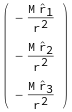
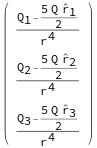

In [804]:
(* from PHANTOM eq. 222 *)
aMPhantom = -M/r^2*urh;
aQPhantom = 1/r^4*Array[(Subscript[Q, #] - 5/2*urh[[#]]*Q) &, {3}];

(* symbolic test *)
aM = -M/SquareLength[rv]*ur;
aQ = 1/SquareLength[rv]^2*(Qi - 5/2*ur*(ur.Qi));

aMPhantom // MatrixForm
FullSimplify[DoExpand[aMPhantom] - DoCollapse[aM]]

aQPhantom // MatrixForm
FullSimplify[DoExpand[aQPhantom] - DoCollapse[aQ]]

### Eq. 226

^ 2        ^  ^             ^  ^
M (-1 + 3 r  )   3 M r  r         3 M r  r
           1          1  2             1  3
--------------   ---------        ---------
       3             3                3
      r             r                r

    ^  ^                   ^ 2        ^  ^
3 M r  r         M (-1 + 3 r  )   3 M r  r
     1  2                   2          2  3
---------        --------------   ---------
    3                   3             3
   r                   r             r

    ^  ^             ^  ^                   ^ 2
3 M r  r         3 M r  r         M (-1 + 3 r  )
     1  3             2  3                   3
---------        ---------        --------------
    3                3                   3
   r                r                   r
0
                                  ^ 2                                         ^  ^
                               35 r                                      35 Q r  r
                ^         5        1                      ^         ^          1  2
Q       - 10 Q  r  + Q (-(-) + ------)     Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 1}       1  1        2      2          {1, 2}      2  1      1  2       2
--------------------------------------     ----------------------------------------
                   5                                           5
                  r                                           r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          1  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {1, 3}      3  1      1  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                      ^ 2
                              35 Q r  r                                   35 r
               ^         ^          1  2                   ^         5        2
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 10 Q  r  + Q (-(-) + ------)
 {1, 2}      2  1      1  2       2         {2, 2}       2  2        2      2
----------------------------------------   --------------------------------------
                    5                                         5
                   r                                         r
 
                                           ^  ^
                                      35 Q r  r
                       ^         ^          2  3
        Q       - 5 Q  r  - 5 Q  r  + ----------
         {2, 3}      3  2      2  3       2
        ----------------------------------------
                            5
>                          r

                                   ^  ^                                       ^  ^
                              35 Q r  r                                  35 Q r  r
               ^         ^          1  3                  ^         ^          2  3
Q       - 5 Q  r  - 5 Q  r  + ----------   Q       - 5 Q  r  - 5 Q  r  + ----------
 {1, 3}      3  1      1  3       2         {2, 3}      3  2      2  3       2
----------------------------------------   ----------------------------------------
                    5                                          5
                   r                                          r
 
                                          ^ 2
                                       35 r
                        ^         5        3
        Q       - 10 Q  r  + Q (-(-) + ------)
         {3, 3}       3  3        2      2
        --------------------------------------
                           5
>                         r
0
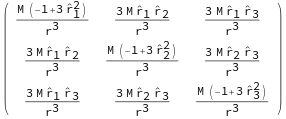
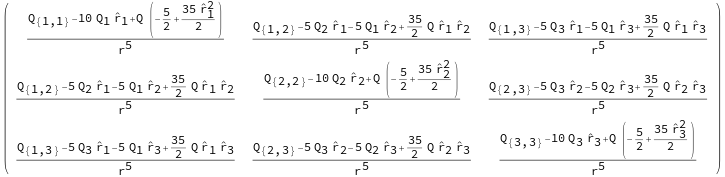

In [814]:
(* from PHANTOM eq. 226 *)
daMPhantom = M/r^3*Array[3*urh[[#]]*urh[[#2]] - KroneckerDelta[#, #2] &, {3, 3}];
daQPhantom = 1/r^5*Array[
  Qij[[#, #2]]
  + (35/2*urh[[#]]*urh[[#2]] - 5/2*KroneckerDelta[#, #2])*Q
  - 5*urh[[#]]*Subscript[Q, #2] - 5*urh[[#2]]*Subscript[Q, #]
  &, {3, 3}];

(* symbolic test *)
daM = D[aM, {rv}];
daQ = D[aQ, {rv}];

daMPhantom // MatrixForm
FullSimplify[DoCollapse[daM] - DoExpand[daMPhantom]]

daQPhantom // MatrixForm
FullSimplify[DoCollapse[daQ] - DoExpand[daQPhantom]]

### Eq. 227

^      ^ 3            ^      ^ 2 ^            ^      ^ 2 ^
-3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r   r )
          1      1              2      1   2            3      1   3
--------------------    ---------------------   ---------------------
          4                       4                       4
         r                       r                       r
       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r

       ^      ^ 2 ^            ^      ^  ^ 2          ^  ^  ^
-3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )   -15 M r  r  r
        2      1   2            1      1  2            1  2  3
---------------------   ---------------------   --------------
          4                       4                    4
         r                       r                    r
       ^      ^  ^ 2             ^      ^ 3            ^      ^ 2 ^
-3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )    -3 M (-r  + 5 r   r )
        1      1  2               2      2              3      2   3
---------------------   --------------------    ---------------------
          4                       4                       4
         r                       r                       r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r

       ^      ^ 2 ^           ^  ^  ^                  ^      ^  ^ 2
-3 M (-r  + 5 r   r )   -15 M r  r  r           -3 M (-r  + 5 r  r  )
        3      1   3           1  2  3                  1      1  3
---------------------   --------------          ---------------------
          4                    4                          4
         r                    r                          r
      ^  ^  ^                  ^      ^ 2 ^            ^      ^  ^ 2
-15 M r  r  r           -3 M (-r  + 5 r   r )   -3 M (-r  + 5 r  r  )
       1  2  3                  3      2   3            2      2  3
--------------          ---------------------   ---------------------
       4                          4                       4
      r                          r                       r
       ^      ^  ^ 2           ^      ^  ^ 2             ^      ^ 3
-3 M (-r  + 5 r  r  )   -3 M (-r  + 5 r  r  )   -3 M (-3 r  + 5 r  )
        1      1  3             2      2  3               3      3
---------------------   ---------------------   --------------------
          4                       4                       4
         r                       r                       r
0
                                                                                   ^
                                                                              35 Q r
                                                                                    2
                                                                     (-5 Q  + ------- - 
                                                                          2      2
                                                                      
            
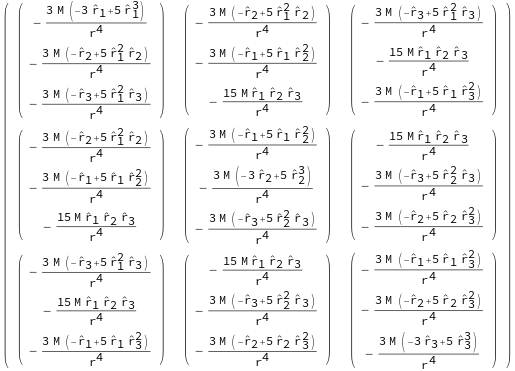
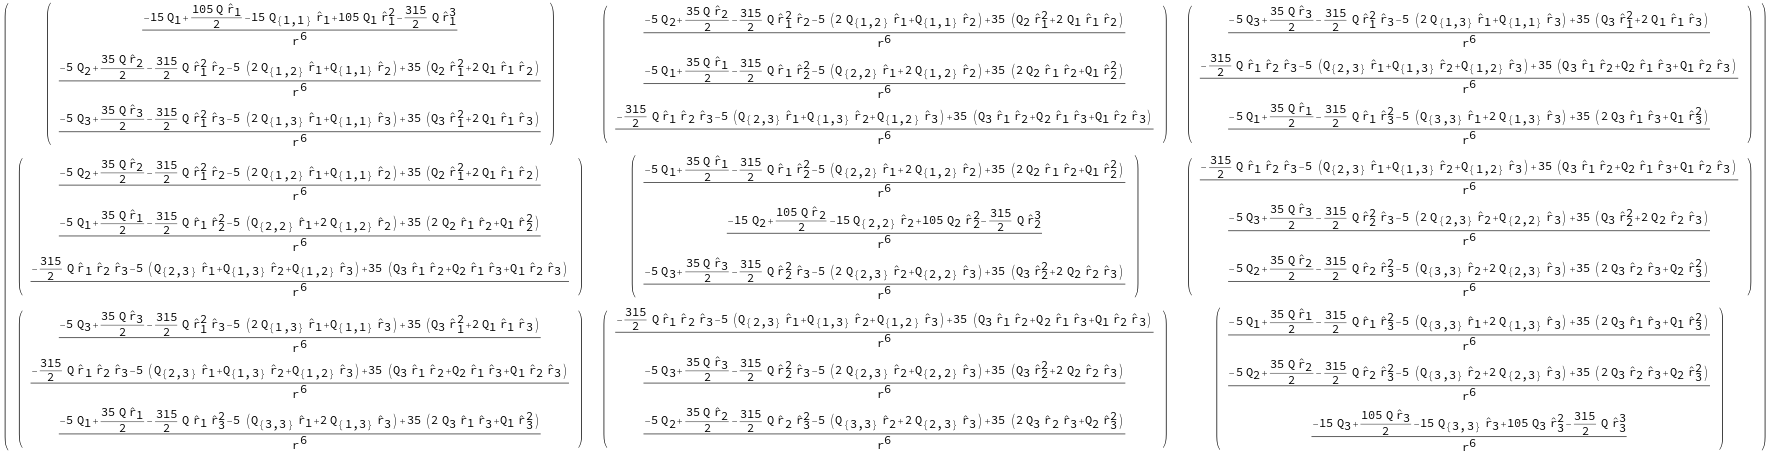

In [824]:
(* from PHANTOM eq. 227 *)
d2aMPhantom = -3*M/r^4*Array[
  5*urh[[#]]*urh[[#2]]*urh[[#3]]
  - KroneckerDelta[#2, #3]*urh[[#]]
  - KroneckerDelta[#, #3]*urh[[#2]]
  - KroneckerDelta[#, #2]*urh[[#3]]
  &, {3, 3, 3}
  ];
d2aQPhantom = 1/r^6*Array[
  - 5*(urh[[#3]]*Qij[[#, #2]] + urh[[#]]*Qij[[#2, #3]] + urh[[#2]]*Qij[[#, #3]])
  - 315/2*urh[[#]]*urh[[#2]]*urh[[#3]]*Q
  + 35/2*(KroneckerDelta[#, #2]*urh[[#3]] + KroneckerDelta[#, #3]*urh[[#2]] + KroneckerDelta[#2, #3]*urh[[#]])*Q
  + 35*(urh[[#2]]*urh[[#3]]*Subscript[Q, #] + urh[[#]]*urh[[#3]]*Subscript[Q, #2] + urh[[#]]*urh[[#2]]*Subscript[Q, #3])
  - 5*(KroneckerDelta[#, #2]*Subscript[Q, #3] + KroneckerDelta[#, #3]*Subscript[Q, #2] + KroneckerDelta[#2, #3]*Subscript[Q, #])
  &, {3, 3, 3}
  ];

(* symbolic test *)
d2aM = D[daM, {rv}];
d2aQ = D[daQ, {rv}];

d2aMPhantom // MatrixForm
FullSimplify[DoCollapse[d2aM] - DoExpand[d2aMPhantom]]

d2aQPhantom // MatrixForm
FullSimplify[DoCollapse[d2aQ] - DoExpand[d2aQPhantom]]

### Conclusion: the formulas are <span style="color:green">correct!</span>

## Checking the symmetry of the node-node interaction force

**Let's take the mass of the particle as unit**

**All particles have equal masses which is enforced in PHANTOM**

In [828]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* number of particles in each nodes *)
Np = {2, 3};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

### Definition of dx

Δx         Δx         Δx
  1,1,1      1,1,2      1,1,3

-Δx        -Δx        -Δx
   1,1,1      1,1,2      1,1,3
Δx                   Δx                   Δx
  2,1,1                2,1,2                2,1,3

Δx                   Δx                   Δx
  2,2,1                2,2,2                2,2,3

-Δx      - Δx        -Δx      - Δx        -Δx      - Δx
   2,1,1     2,2,1      2,1,2     2,2,2      2,1,3     2,2,3
{2, 3, 3}
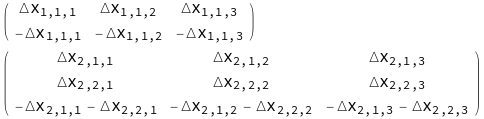

In [840]:
ClearAll@dx
ClearAll@DefineDx

DefineDx[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    dx0
  },

  (* dx the relative distance of each particle from the node centre of mass *)
  dx0 = Array[Subscript[\[CapitalDelta]x, ##] &, {Nn, maxNp, 3}];
  (* by determining the center of mass of the node *)
  Do[
    dx0[[n, Np[[n]]]] =
    If[
      Np[[n]] <= 1
      , {0, 0, 0}
      , - Sum[dx0[[n, p]], {p, Np[[n]] - 1}]
    ]
    , {n, 1, Nn}
  ];

  dx0
]

dx = DefineDx[Np];

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]

### Redefinition of r

r
0          {1, 2}

r
 {1, 2}   0
              ^
              r
0              {1, 2, 1}
              ^
              r
0              {1, 2, 2}
              ^
              r
0              {1, 2, 3}

 ^
-r
  {1, 2, 1}   0
 ^
-r
  {1, 2, 2}   0
 ^
-r
  {1, 2, 3}   0
{_ ∈ Reals, (r       | r      ) ∈ Reals && r       > 0 && r       > 0, 
              {1, 2}    {1, 2}              {1, 2}         {1, 2}
 
    ^         2   ^         2   ^         2
>   r           + r           + r           == 1}
     {1, 2, 1}     {1, 2, 2}     {1, 2, 3}
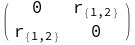
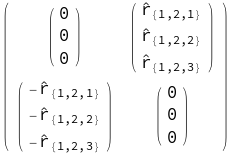

In [849]:
(* distance between nodes *)
ClearAll@r
ClearAll@DefineR

DefineR[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    rnm0,
    urh0
  },

  rnm0 = Normal@ SymmetrizedArray[{i_, j_} -> Subscript[r, {i, j}], {Nn, Nn}, Symmetric[{1, 2}]];

  (* https://mathematica.stackexchange.com/questions/92666/how-to-zero-or-replace-the-diagonal-of-a-square-matrix *)
  (* rnm0 = ReplacePart[rnm0, {i_, i_} -> 0]; *)
  rnm0 = UpperTriangularize[rnm0, 1] + LowerTriangularize[rnm0, -1];

  (* unit vector r with hat *)
  (* h means hat *)
  urh0 = Normal@ SymmetrizedArray[{i_, j_, k_} -> Subscript[OverHat[r], {i, j, k}], {Nn, Nn, 3}, Antisymmetric[{1, 2}]];

  $Assumptions = {
    (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
    _ \[Element] Reals,
    (* https://mathematica.stackexchange.com/questions/220317/how-to-best-add-assumption-that-many-variables-are-positive *)
    SparseArray[rnm0]["NonzeroValues"] \[Element] PositiveReals
  };
  $Assumptions = Join[
    $Assumptions, Flatten@Table[urh0[[n, m, 1]]^2 + urh0[[n, m, 2]]^2 + urh0[[n, m, 3]]^2 == 1, {n, Nn}, {m, n+1, Nn}]
  ];

  {rnm0, urh0}
]

rAll = DefineR[Np];
rnm = rAll[[1]];
rnm // MatrixForm
urh = rAll[[2]];
urh // MatrixForm

$Assumptions

### Redefinition of quadrupole moments

2            2            2
4 Δx       - 2 Δx       - 2 Δx          6 Δx      Δx
    1,1,1        1,1,2        1,1,3         1,1,1   1,1,2
 

     6 Δx      Δx
>        1,1,1   1,1,3

                                                  2            2            2
6 Δx      Δx                            -2 Δx       + 4 Δx       - 2 Δx
    1,1,1   1,1,2                            1,1,1        1,1,2        1,1,3
 

     6 Δx      Δx
>        1,1,2   1,1,3


6 Δx      Δx                            6 Δx      Δx
    1,1,1   1,1,3                           1,1,2   1,1,3
 
               2            2            2
     -2 Δx       - 2 Δx       + 4 Δx
>         1,1,1        1,1,2        1,1,3
         2          2          2                         2            2      3 Δx      
2 Δx       - Δx       - Δx       + 2 (-Δx      - Δx     )  + 2 Δx       -        2,1,1
    2,1,1      2,1,2      2,1,3          2,1,1     2,2,1         2,2,1        
                                                                             >    Δx
                        2          2                       2          2             2,1,2
>   (-Δx      - Δx     )  - Δx       - (-Δx      - Δx     )  - Δx             
        2,1,2     2,2,2       2,2,2        2,1,3     2,2,3       2,2,3       >     + 3 
                                                                              
                                                                             >    (-Δx
                                                                              
                                                                             >      
                                                                                    2,1,1
                                                                              
                                                                             >       - Δx
                                                                              
                                                                             >      
                                                                                    2,2,1
                                                                              
                                                                             >      ) 
                                                                              
                                                                             >    (-Δx
                                                                              
                                                                             >      
                                                                                    2,1,2
                                                                              
                                                                             >       - Δx
                                                                              
                                                                             >      
                                                                                    2,2,2
                                                                              
                                                                             >      ) + 
                                                                              
                                                                             >   3 
                                                                              
                                                                             >    Δx
                                                                              
                                                                             >           
                                                                                   2,2,1
                                                                              
                            
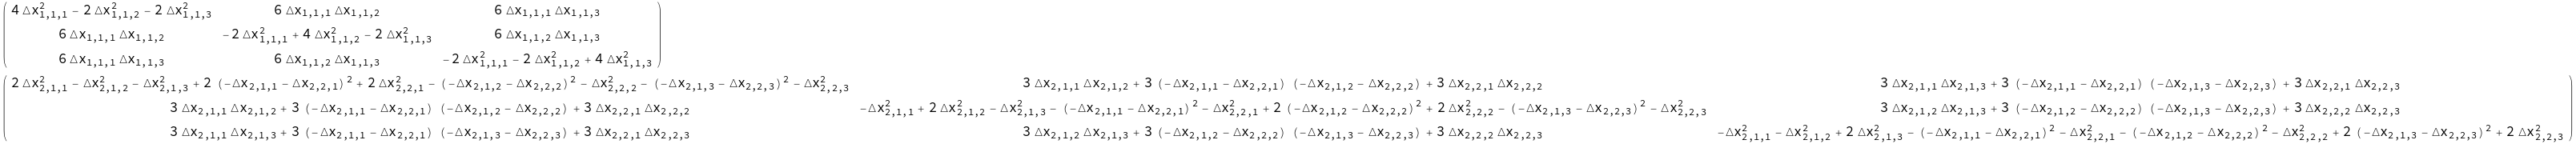
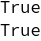
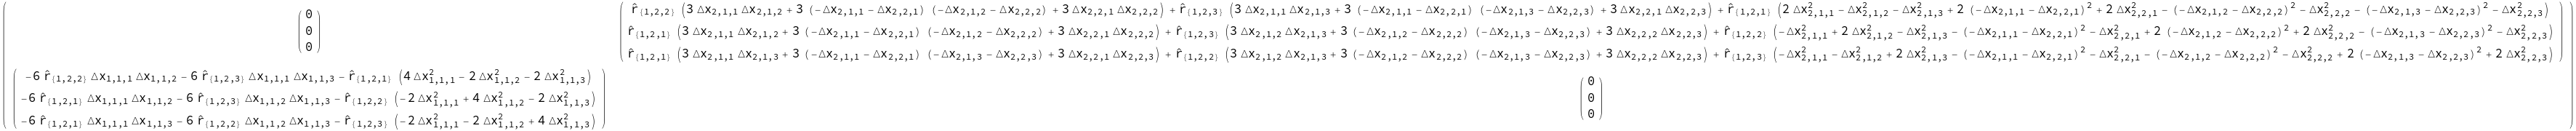
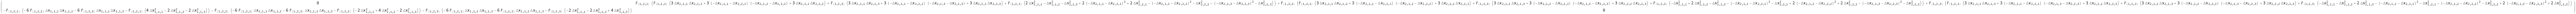

In [858]:
ClearAll@Qij
ClearAll@DefineQij

DefineQij[Np_] := Module[
  {
    (* number of nodes *)
    Nn = Length[Np],
    (* maximum number of paticles *)
    maxNp = Max[Np],
    Qijp,
    Qij0,
    Qi0Full,
    Qi0,
    Q0Full,
    Q0
  },

  Qijp = Array[3*dx[[#, #2, #3]]*dx[[#, #2, #4]] - SquareLength[dx[[#, #2]]]*KroneckerDelta[#3, #4] &, {Nn, maxNp, 3, 3}];
  Qij0 = Array[Subscript[Q, ##] &, {Nn, 3, 3}];
  Do[Qij0[[n]] = ParallelSum[Qijp[[n, p]], {p, Np[[n]]}], {n, 1, Nn}];

  Qi0Full = EinsteinSummation[{{n, m1, j}, {m2, i, j}}, {urh, Qij0}];
  (* get diagonal *)
  Qi0 = ParallelTable[Qi0Full[[n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  Q0Full = EinsteinSummation[{{n1, m1, i}, {n2, m2, j}, {m3, i, j}}, {urh, urh, Qij0}];
  (* get diagonal *)
  Q0 = ParallelTable[Q0Full[[n, m, n, m, m]], {n, 1, Nn}, {m, 1, Nn}];

  {Qij0, Qi0, Q0}
]

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

(* Q is a symmetric tensor, only six independent quantities need to be stored (Qxx, Qxy, Qxz, Qyy, Qyz and Qzz) *)
Column[Table[SymmetricMatrixQ[Qij[[n]]] // MatrixForm, {n, 1, Nn}]]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, node m, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n, node m *)
Dimensions[Q]


### Node_1 <- Node_2 =? Node_2 <- Node_1

#### Eq. 222

In [877]:
(* NB: without r *)

ClearAll@aMPhantom
aMPhantom[Np_] := Array[-Np[[#2]]*urh[[#, #2]] &, {Length[Np], Length[Np]}];

ClearAll@aQPhantom
aQPhantom[Np_] := Array[(Qi[[#, #2, #3]] - 5/2*urh[[#, #2, #3]]*Q[[#, #2]]) &, {Length[Np], Length[Np], 3}];

(* node n, node m, components a *)
Dimensions[aMPhantom[Np]]
Dimensions[aQPhantom[Np]]

{2, 2, 3}
{2, 2, 3}

#### 1 terms in eq. 228

In [879]:
ClearAll@fMPhantom
fMPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^2*Np[[n]]*aMPhantom[Np][[n, m]]

ClearAll@fQPhantom
fQPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^4*Np[[n]]*aQPhantom[Np][[n, m]]

#### Eq. 226

In [889]:
(* NB: without r *)

ClearAll@daMPhantom
daMPhantom[Np_] := Array[Np[[#2]]*(3*urh[[#, #2, #3]]*urh[[#, #2, #4]] - KroneckerDelta[#3, #4]) &, {Length[Np], Length[Np], 3, 3}];

ClearAll@daQPhantom
daQPhantom[Np_] := Array[
  Qij[[#2, #3, #4]]
  + (35/2*urh[[#, #2, #3]]*urh[[#, #2, #4]] - 5/2*KroneckerDelta[#3, #4])*Q[[#, #2]]
  - 5*urh[[#, #2, #3]]*Qi[[#, #2, #4]] - 5*urh[[#, #2, #4]]*Qi[[#, #2, #3]]
  &, {Length[Np], Length[Np], 3, 3}];

(* node n, node m, components a, components r *)
Dimensions[daMPhantom[Np]]
Dimensions[daQPhantom[Np]]

{2, 2, 3, 3}
{2, 2, 3, 3}

#### 2 terms in eq. 228

In [902]:
ClearAll@a2MPhantomFull
a2MPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daMPhantom[Np]}];
ClearAll@a2MPhantom
(* get diagonal *)
a2MPhantom[Np_] := Table[a2MPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

ClearAll@a2QPhantomFull
a2QPhantomFull[Np_] := EinsteinSummation[{{n1, p, j}, {n2, m, i, j}}, {dx, daQPhantom[Np]}];
ClearAll@a2QPhantom
(* get diagonal *)
a2QPhantom[Np_] := Table[a2QPhantomFull[Np][[n, All, n]], {n, 1, Length[Np]}];

(* node n, p from n, node m, components a *)
Dimensions[a2MPhantom[Np]]
Dimensions[a2QPhantom[Np]]

ClearAll@f2MPhantom
f2MPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^3*Sum[a2MPhantom[Np][[n, p, m]], {p, Np[[n]]}];

ClearAll@f2QPhantom
f2QPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^5*Sum[a2QPhantom[Np][[n, p, m]], {p, Np[[n]]}];

{2, 3, 2, 3}
{2, 3, 2, 3}

#### Eq. 227

In [914]:
(* NB: without r *)

ClearAll@d2aMPhantom
d2aMPhantom[Np_] := Array[
  Np[[#2]]*
  (5*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]
  - KroneckerDelta[#4, #5]*urh[[#, #2, #3]]
  - KroneckerDelta[#3, #5]*urh[[#, #2, #4]]
  - KroneckerDelta[#3, #4]*urh[[#, #2, #5]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

ClearAll@d2aQPhantom
d2aQPhantom[Np_] := Array[
  - 5*(urh[[#, #2, #5]]*Qij[[#2, #3, #4]] + urh[[#, #2, #3]]*Qij[[#2, #4, #5]] + urh[[#, #2, #4]]*Qij[[#2, #3, #5]])
  - 315/2*urh[[#, #2, #3]]*urh[[#, #2, #4]]*urh[[#, #2, #5]]*Q[[#, #2]]
  + 35/2*(KroneckerDelta[#3, #4]*urh[[#, #2, #5]] + KroneckerDelta[#3, #5]*urh[[#, #2, #4]] + KroneckerDelta[#4, #5]*urh[[#, #2, #3]])*Q[[#, #2]]
  + 35*(urh[[#, #2, #4]]*urh[[#, #2, #5]]*Qi[[#, #2, #3]] + urh[[#, #2, #3]]*urh[[#, #2, #5]]*Qi[[#, #2, #4]] + urh[[#, #2, #3]]*urh[[#, #2, #4]]*Qi[[#, #2, #5]])
  - 5*(KroneckerDelta[#3, #4]*Qi[[#, #2, #5]] + KroneckerDelta[#3, #5]*Qi[[#, #2, #4]] + KroneckerDelta[#4, #5]*Qi[[#, #2, #3]])
  &, {Length[Np], Length[Np], 3, 3, 3}
  ];

(* node n, node m, components a, components r, components r *)
Dimensions[d2aMPhantom[Np]]
TensorRank[d2aMPhantom[Np]]
Dimensions[d2aQPhantom[Np]]
TensorRank[d2aQPhantom[Np]]

{2, 2, 3, 3, 3}
5
{2, 2, 3, 3, 3}
5

#### 3 terms in eq. 228

In [921]:
ClearAll@a3MPhantomFull
a3MPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aMPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3MPhantomFull[Np]]
TensorRank[a3MPhantomFull[Np]]

ClearAll@a3MPhantom
(* get diagonal *)
a3MPhantom[Np_] := ParallelTable[a3MPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3MPhantom[Np]]
TensorRank[a3MPhantom[Np]]

ClearAll@a3QPhantomFull
a3QPhantomFull[Np_] := 1/2*EinsteinSummation[{{n1, p1, j}, {n2, p2, k}, {n3, m, i, j, k}}, {dx, dx, d2aQPhantom[Np]}];
(* node n, p from n, node n, p from n, node n, node m, components a *)
Dimensions[a3QPhantomFull[Np]]
TensorRank[a3QPhantomFull[Np]]

ClearAll@a3QPhantom
(* get diagonal *)
a3QPhantom[Np_] := ParallelTable[a3QPhantomFull[Np][[n, p, n, p, n]], {n, 1, Length[Np]}, {p, 1, Max[Np]}];
(* node n, p from n, node m, components a *)
Dimensions[a3QPhantom[Np]]
TensorRank[a3QPhantom[Np]]

ClearAll@f3MPhantom
f3MPhantom[Np_, n_, m_] := -3/rnm[[n, m]]^4*Sum[a3MPhantom[Np][[n, p, m]], {p, Np[[n]]}];

ClearAll@f3QPhantom
f3QPhantom[Np_, n_, m_] := 1/rnm[[n, m]]^6*Sum[a3QPhantom[Np][[n, p, m]], {p, Np[[n]]}];

{2, 3, 2, 3, 2, 2, 3}
7
{2, 3, 2, 3}
4
{2, 3, 2, 3, 2, 2, 3}
7
{2, 3, 2, 3}
4

#### Disbalances

##### 1 term disbalance

{0, 0, 0}
    ^         2  ^
(30 r           (r          (3 Δx      Δx      - Δx      (2 Δx      + Δx     ) - 
     {1, 2, 1}    {1, 2, 2}      1,1,1   1,1,2     2,1,2      2,1,1     2,2,1
 
>           (Δx      + 2 Δx     ) Δx     ) + 
               2,1,1       2,2,1    2,2,2
 
         ^
>        r          (3 Δx      Δx      - Δx      (2 Δx      + Δx     ) - 
          {1, 2, 3}      1,1,1   1,1,3     2,1,3      2,1,1     2,2,1
 
>           (Δx      + 2 Δx     ) Δx     )) + 
               2,1,1       2,2,1    2,2,3
 
         ^
>     6 (r          (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
          {1, 2, 2}       1,1,1   1,1,2     2,1,2      2,1,1     2,2,1
 
>           (Δx      + 2 Δx     ) Δx     ) + 
               2,1,1       2,2,1    2,2,2
 
         ^
>        r          (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
          {1, 2, 3}       1,1,1   1,1,3     2,1,3      2,1,1     2,2,1
 
>           (Δx      + 2 Δx     ) Δx     )) + 
               2,1,1       2,2,1    2,2,3
 
        ^         3           2            2            2
>     5 r           (6 Δx       - 3 Δx       - 3 Δx       + 
         {1, 2, 1}       1,1,1        1,1,2        1,1,3
 
                   2          2             2                            2
>        2 (Δx       + Δx       - 2 (Δx       + Δx      Δx      + Δx      ) + 
              2,1,2      2,1,3         2,1,1      2,1,1   2,2,1     2,2,1
 
                                     2                            2
>           Δx      Δx      + Δx       + Δx      Δx      + Δx      )) + 
              2,1,2   2,2,2     2,2,2      2,1,3   2,2,3     2,2,3
 
      ^                     ^         2     ^         2         2            2
>     r          (-3 (4 + 5 r           + 5 r          ) Δx       + 6 Δx       - 
       {1, 2, 1}             {1, 2, 2}       {1, 2, 3}     1,1,1        1,1,2
 
            ^         2        2            2      ^         2        2            2
>        15 r           Δx       + 6 Δx       + 30 r           Δx       + 8 Δx       + 
             {1, 2, 3}    1,1,2        1,1,3        {1, 2, 3}    1,1,3        2,1,1
 
            ^         2        2            2      ^         2        2            2
>        10 r           Δx       - 4 Δx       + 10 r           Δx       - 4 Δx       - 
             {1, 2, 3}    2,1,1        2,1,2        {1, 2, 3}    2,1,2        2,1,3
 
            ^         2        2                          ^         2
>        20 r           Δx       + 8 Δx      Δx      + 10 r           Δx      Δx      + 
             {1, 2, 3}    2,1,3        2,1,1   2,2,1       {1, 2, 3}    2,1,1   2,2,1
 
                  2      ^         2        2
>        8 Δx       + 10 r           Δx       - 4 Δx      Δx      + 
             2,2,1        {1, 2, 3}    2,2,1        2,1,2   2,2,2
 
            ^         2                            2      ^         2        2
>        10 r           Δx      Δx      - 4 Δx       + 10 r           Δx       - 
             {1, 2, 3}    2,1,2   2,2,2       2,2,2        {1, 2, 3}    2,2,2
 
                  ^         2                             ^         2         2
>        4 (1 + 5 r          ) Δx      Δx      - 4 (1 + 5 r          ) Δx       + 
                   {1, 2, 3}     2,1,3   2,2,3             {1, 2, 3}     2,2,3
 
            ^          ^
>        30 r          r          (3 Δx      Δx      - Δx      (2 Δx      + Δx     ) - 
             {1, 2, 2}  {1, 2, 3}      1,1,2   1,1,3     2,1,2      2,1,3     2,2,3
 
>           Δx      (Δx      + 2 Δx     )) + 
              2,2,2    2,1,3       2,2,3
 
           ^         2           2            2
>        5 r           (6 Δx       - 3 Δx       + 
            {1, 2, 2}       1,1,2        1,1,3
 
                      2          2                            2
>           2 (Δx       + Δx       + Δx      Δx      + Δx       - 
                 2,1,1      2,1,3      2,1,1   2,2,1     2,2,1
 
                         2                      
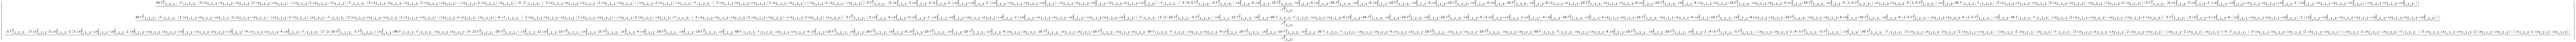

In [944]:
disbalancefM = fMPhantom[Np, 1, 2] + fMPhantom[Np, 2, 1]
disbalancefQ = fQPhantom[Np, 1, 2] + fQPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancefQ] // MatrixForm

##### 2 term disbalance

In [947]:
ParallelMap[FullSimplify, {
  f2MPhantom[Np, 1, 2],
  f2MPhantom[Np, 2, 1],
  f2QPhantom[Np, 1, 2],
  f2QPhantom[Np, 2, 1]}
]

{{0, 0, 0}, {0, 0, 0}, {0, 0, 0}, {0, 0, 0}}

##### 3 term disbalance

^         3            2             2                            2
(3 (5 r           (-3 Δx       + 2 (Δx       + Δx      Δx      + Δx      )) + 
       {1, 2, 1}        1,1,1         2,1,1      2,1,1   2,2,1     2,2,1
 
        ^
>       r          (6 Δx      Δx      - 2 Δx      (2 Δx      + Δx     ) - 
         {1, 2, 2}      1,1,1   1,1,2       2,1,1      2,1,2     2,2,2
 
>          2 Δx      (Δx      + 2 Δx     )) + 
               2,2,1    2,1,2       2,2,2
 
          ^
>       2 r          (3 Δx      Δx      - Δx      (2 Δx      + Δx     ) - 
           {1, 2, 3}      1,1,1   1,1,3     2,1,1      2,1,3     2,2,3
 
>          Δx      (Δx      + 2 Δx     )) + 
             2,2,1    2,1,3       2,2,3
 
           ^         2  ^
>       10 r           (r          (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
            {1, 2, 1}    {1, 2, 2}       1,1,1   1,1,2     2,1,2      2,1,1     2,2,1
 
>             (Δx      + 2 Δx     ) Δx     ) + 
                 2,1,1       2,2,1    2,2,2
 
           ^
>          r          (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
            {1, 2, 3}       1,1,1   1,1,3     2,1,3      2,1,1     2,2,1
 
>             (Δx      + 2 Δx     ) Δx     )) + 
                 2,1,1       2,2,1    2,2,3
 
        ^                    2           ^         2         2
>       r          (9 Δx       + (3 - 15 r          ) Δx       - 
         {1, 2, 1}      1,1,1             {1, 2, 2}     1,1,2
 
              ^          ^                                    ^         2         2
>          30 r          r          Δx      Δx      + (3 - 15 r          ) Δx       - 
               {1, 2, 2}  {1, 2, 3}   1,1,2   1,1,3            {1, 2, 3}     1,1,3
 
                     2             2                            2
>          2 (Δx       + 3 (Δx       + Δx      Δx      + Δx      )) + 
                2,1,2         2,1,1      2,1,1   2,2,1     2,2,1
 
>          2 (-(Δx      (Δx      + Δx     )) + 
                  2,2,2    2,1,2     2,2,2
 
                ^         2         2                            2
>             5 r           (Δx       + Δx      Δx      + Δx      ) + 
                 {1, 2, 2}     2,1,2      2,1,2   2,2,2     2,2,2
 
                      ^         2          2                            2
>             (-1 + 5 r          ) (Δx       + Δx      Δx      + Δx      ) + 
                       {1, 2, 3}      2,1,3      2,1,3   2,2,3     2,2,3
 
                ^          ^
>             5 r          r          
                 {1, 2, 2}  {1, 2, 3}
 
>              (Δx      (2 Δx      + Δx     ) + Δx      (Δx      + 2 Δx     )))))) / 
                  2,1,2      2,1,3     2,2,3      2,2,2    2,1,3       2,2,3
 
           4
>   r
     {1, 2}

    ^
(3 (r          (6 Δx      Δx      - 2 Δx      (2 Δx      + Δx     ) - 
     {1, 2, 1}      1,1,1   1,1,2       2,1,1      2,1,2     2,2,2
 
>          2 Δx      (Δx      + 2 Δx     )) + 
               2,2,1    2,1,2       2,2,2
 
          ^         3            2             2                            2
>       5 r           (-3 Δx       + 2 (Δx       + Δx      Δx      + Δx      )) + 
           {1, 2, 2}        1,1,2         2,1,2      2,1,2   2,2,2     2,2,2
 
          ^
>       2 r          (3 Δx      Δx      - Δx      (2 Δx      + Δx     ) - 
           {1, 2, 3}      1,1,2   1,1,3     2,1,2      2,1,3     2,2,3
 
>          Δx      (Δx      + 2 Δx     )) + 
             2,2,2    2,1,3       2,2,3
 
           ^         2  ^
>       10 r           (r          (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
            {1, 2, 2}    {1, 2, 1}       1,1,1   1,1,2     2,1,2      2,1,1     2,2,1
 
>             (Δx      + 2 Δx     ) Δx     ) + 
                 2,1,1       2,2,1    2,2,2
 
           ^
>          r          (-3 Δx      Δx      + Δx      (2 Δx      + Δx     ) + 
            {1, 2, 3}       1,1,2   1,1,3     2,1,3      2,1,2     2,2,2
 
>             (Δx      + 2 Δx     ) Δx     )) + 
    
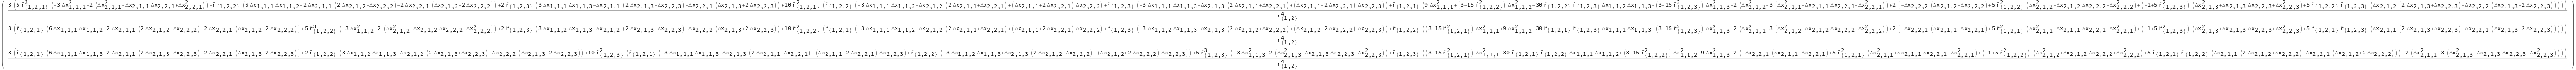

In [949]:
disbalancef3M = f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 2, 1];
ParallelMap[FullSimplify, disbalancef3M] // MatrixForm

disbalancef3Q = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 2, 1];
FullSimplify[disbalancef3Q]

### Conclusion: node-node interaction are <span style="color:green">symmetric</span> up to 1/r^6!

In [952]:
FullSimplify[disbalancefQ + disbalancef3M]

{0, 0, 0}

## Additional force due to asymmetry of the tree

0









0









0
 









     1









     0









>    0
 




               r       + Δx
                {1, 2}     2,1,1
     -------------------------------------
                 2                      2
     Sqrt[Δx       + (r       + Δx     ) ]
            2,1,1      {1, 2}     2,1,1




                    Δx
                      2,1,1
     -------------------------------------
                 2                      2
     Sqrt[Δx       + (r       + Δx     ) ]
            2,1,1      {1, 2}     2,1,1









>    0
 
                         Δx
                           2,1,1
               r       - -------
                {1, 2}      2
     -------------------------------------
                                        2
                     Δx          Δx
                       2,1,1 2     2,1,1
     Sqrt[(r       - -------)  + --------]
            {1, 2}      2           4


                         Δx
       1                   2,1,1
     -(-) -------------------------------------
       2                                     2
                          Δx          Δx
                            2,1,1 2     2,1,1
          Sqrt[(r       - -------)  + --------]
                 {1, 2}      2           4









>    0










-1









0









0
 









     0









     0









>    0
 







     ^
     r
      {2, 3, 1}







     ^
     r
      {2, 3, 2}









>    0
 







     ^
     r
      {2, 4, 1}







     ^
     r
      {2, 4, 2}









>    0





            r       + Δx
             {1, 2}     2,1,1
-(-------------------------------------)
              2                      2
  Sqrt[Δx       + (r       + Δx     ) ]
         2,1,1      {1, 2}     2,1,1




                 Δx
                   2,1,1
-(-------------------------------------)
              2                      2
  Sqrt[Δx       + (r       + Δx     ) ]
         2,1,1      {1, 2}     2,1,1









0
 







      ^
     -r
       {2, 3, 1}







      ^
     -r
       {2, 3, 2}









>    0
 









     0









     0









>    0
 







     ^
     r
      {3, 4, 1}







     ^
     r
      {3, 4, 2}









>    0

                      Δx
                        2,1,1
            r       - -------
             {1, 2}      2
-(-------------------------------------)
                                     2
                  Δx          Δx
                    2,1,1 2     2,1,1
  Sqrt[(r       - -------)  + --------]
         {1, 2}      2           4


                Δx
                  2,1,1
---------------------------------------
                                     2
                  Δx          Δx
                    2,1,1 2     2,1,1
2 Sqrt[(r       - -------)  + --------]
         {1, 2}      2           4









0
 







      ^
     -r
       {2, 4, 1}







      ^
     -r
       {2, 4, 2}









>    0
 







      ^
     -r
       {3, 4, 1}







      ^
     -r
       {3, 4, 2}









>    0
 









     0









     0









>    0
Δx         Δx         Δx
  1,1,1      1,1,2      1,1,3

-Δx        -Δx        -Δx
   1,1,1      1,1,2      1,1,3

Δx             Δx
  2,1,1          2,1,1        0

  1              1
-(-) Δx        -(-) Δx
  2    2,1,1     2    2,1,1   0

  1              1
-(-) Δx        -(-) Δx
  2    2,1,1     2    2,1,1   0
0   0   0
0   0   0

0   0   0
{4, 3, 3}



                                        r
0                                        {1, 2}
 
                                                                                2
                                                             Δx          Δx
                 2                      2                      2,1,1 2     2,1,1
     Sqrt[Δx       + (r       + Δx     ) ]   Sqrt[(r       - -------)  + --------]
>           2,1,1      {1, 2}     2,1,1             {1, 2}      2           4




r
 {1, 2}                                 0
 



     r             
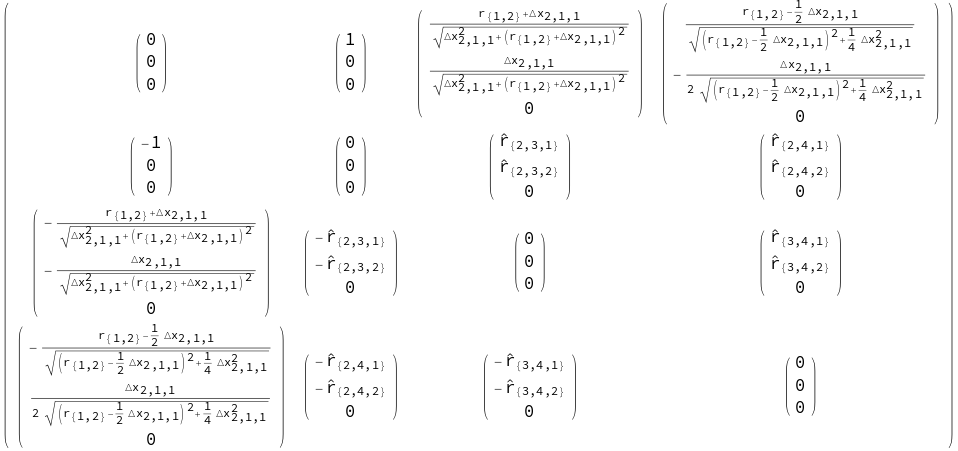
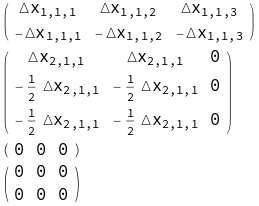
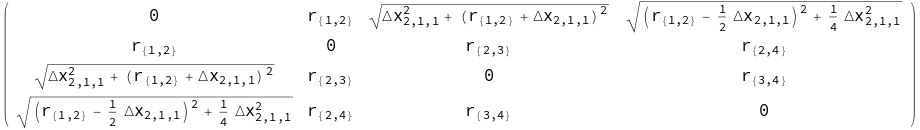
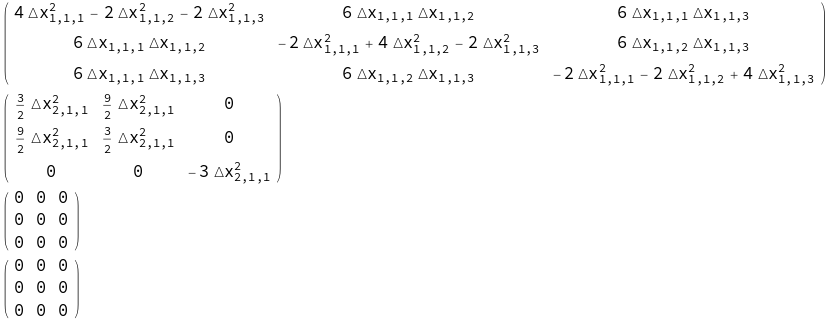
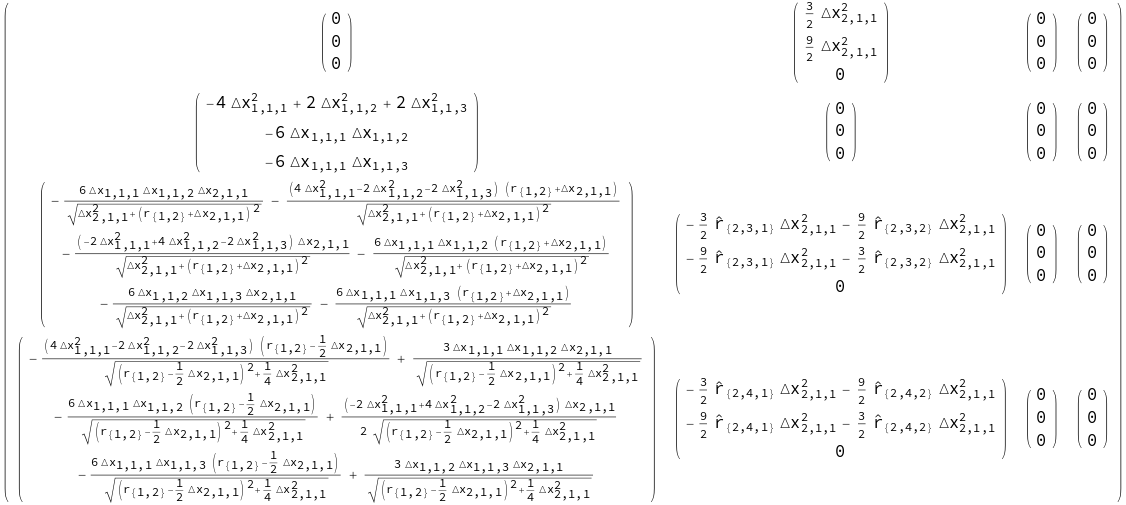
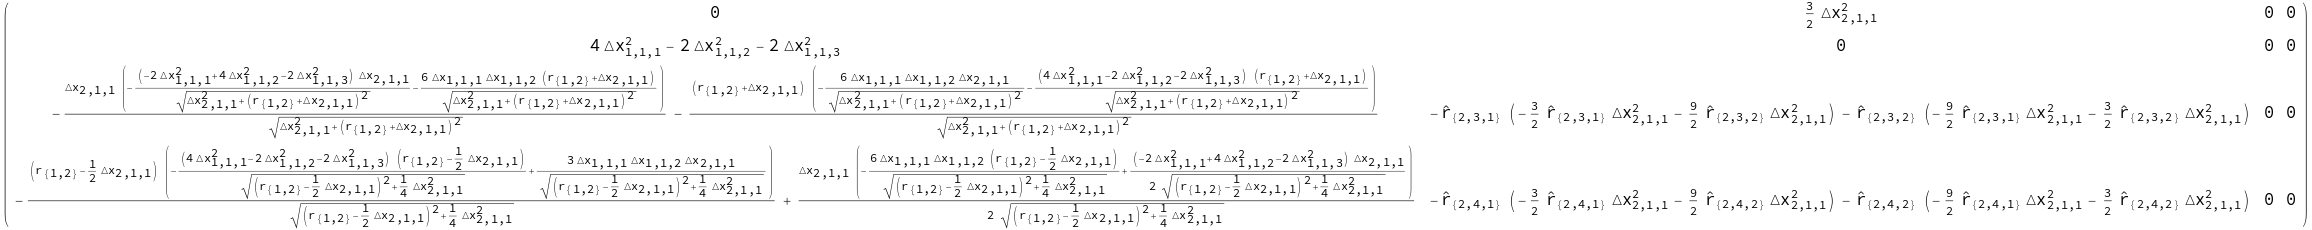

In [981]:
(* Drop assumptions *)
$Assumptions = {
  (* https://mathematica.stackexchange.com/questions/118955/how-to-assume-all-variables-in-my-code-are-reals *)
  _ \[Element] Reals
};

(* system of 4 nodes
A <- B(b1, b2)
b1 <- A
b2 <- A *)
(* Np = {A, B, b1, b2}; *)
Np = {2, 3, 1, 2};
(* number of nodes *)
Nn = Length[Np];
(* maximum number of paticles *)
maxNp = Max[Np];

dx = DefineDx[Np];
rAll = DefineR[Np];
rnm = rAll[[1]];
urh = rAll[[2]];

yRules = MapIndexed[
  # -> rnm[[1, 2]]*Subscript[\[Delta]y, Rest[List @@ #1]] &,
  Flatten[Table[dx[[n, 1;;Np[[n]]-1]], {n, 1, Nn}]]
];

(* Simplification *)

(* 3,4 subnodes are collapsed to dots *)
dx[[3;;4, All, All]] = 0;
(* supernode 2 *)
dx[[2;;4, All, 3]] = 0;
(* unit r *)
urh[[All, All, 3]] = 0;
urh[[1, 2, 1]] = 1;
urh[[2, 1, 1]] = -1;
urh[[1;;2, 1;;2, 2]] = 0;

case = 3;

If[case == 1,
(
(* 1 case: Assume all nodes are along the x axis *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], 1]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], 1]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 2]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = rnm[[1, 2]] + dx[[2, 1, 1]];
rnm[[1, 4]] = rnm[[1, 2]] + dx[[2, Np[[2]], 1]];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[All, All, 2]] = 0;
Do[urh[[n, m, 1]] = 1, {n, 1, Length[Np]}, {m, n + 1, Length[Np]}];
Do[urh[[n, m, 1]] = -1, {m, 1, Length[Np]}, {n, m + 1, Length[Np]}];
)
]

If[case == 2,
(
(* 2 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are along the y axis *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], 2]] = dx[[2, 1, 2]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], 2]] = -dx[[2, 1, 2]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
dx[[2, All, 1]] = 0;
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[rnm[[1, 2]]^2 + dx[[2, Np[[2]], 2]]^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[1, 3, 1]] = rnm[[1, 2]]/rnm[[1, 3]];
urh[[1, 3, 2]] = dx[[2, 1, 2]]/rnm[[1, 3]];
urh[[3, 1, All]] = -urh[[1, 3, All]];
urh[[1, 4, 1]] = rnm[[1, 2]]/rnm[[1, 4]];
urh[[1, 4, 2]] = dx[[2, Np[[2]], 2]]/rnm[[1, 4]];
urh[[4, 1, All]] = -urh[[1, 4, All]];
)
]

If[case == 3,
(
(* 3 case: 1, 2 nodes are along the x axis
  but 3, 4 subnodes of supernode 2 are located at an angle to the x and y axes *)
(* 1 subnodes are collapsed to dots *)
(* only 1 term in eq. 228 does not equal to zero *)
(* dx[[1, All, All]] = 0; *)
(*supernode 2 *)
dx[[2, 1;;Np[[3]], {1,2}]] = dx[[2, 1, 1]]; (* subnode 3 *)
dx[[2, Np[[3]]+1;;Np[[2]], {1,2}]] = -dx[[2, 1, 1]]*Np[[3]]/Np[[4]]; (* subnode 4 *)
(* distance between nodes *)
rnm[[1, 3]] = Sqrt[(rnm[[1, 2]] + dx[[2, 1, 1]])^2 + dx[[2, 1, 2]]^2];
rnm[[1, 4]] = Sqrt[(rnm[[1, 2]] + dx[[2, Np[[2]], 1]])^2 + dx[[2, Np[[2]], 2]]^2];
rnm[[3;;4, 1]] = rnm[[1, 3;;4]];
(* unit r *)
urh[[1, 3, 1]] = (rnm[[1, 2]] + dx[[2, 1, 1]])/rnm[[1, 3]];
urh[[1, 3, 2]] = dx[[2, 1, 2]]/rnm[[1, 3]];
urh[[3, 1, All]] = -urh[[1, 3, All]];

urh[[1, 4, 1]] = (rnm[[1, 2]] + dx[[2, Np[[2]], 1]])/rnm[[1, 4]];
urh[[1, 4, 2]] = dx[[2, Np[[2]], 2]]/rnm[[1, 4]];
urh[[4, 1, All]] = -urh[[1, 4, All]];
)
]

urh //MatrixForm

Column[Table[dx[[n, 1;;Np[[n]]]] // MatrixForm, {n, 1, Nn}]]
(* node n, p from n, components dx *)
Dimensions[dx]
(* node n, node m *)
rnm // MatrixForm

QijAll = DefineQij[Np];

Qij = QijAll[[1]];
Column[Table[Qij[[n]] // MatrixForm, {n, 1, Nn}]]
(* node n, components q, components q *)
Dimensions[Qij]

Qi = QijAll[[2]];
Qi // MatrixForm
(* node n, components q *)
Dimensions[Qi]

Q = QijAll[[3]];
Q // MatrixForm
(* node n *)
Dimensions[Q]

-6
--------
       2
r
 {1, 2}





0





0
              2
-9 δy
     {2, 1, 1}                  4
--------------- + O[δy         ]
           2          {2, 1, 1}
  2 r
     {1, 2}

             2
9 δy
    {2, 1, 1}                  4
-------------- + O[δy         ]
          2          {2, 1, 1}
   r
    {1, 2}







0
0

0

0
0

0

0
                 2              2              2
9 (-2 δy           + δy           + δy          )
        {1, 1, 1}      {1, 1, 2}      {1, 1, 3}
-------------------------------------------------
                           2
                    r
                     {1, 2}


18 δy          δy
     {1, 1, 1}   {1, 1, 2}
--------------------------
                2
         r
          {1, 2}


18 δy          δy
     {1, 1, 1}   {1, 1, 3}
--------------------------
                2
         r
          {1, 2}
                   2                                           2                2
(45 (-4 δy           + 16 δy          δy          + δy           + 3 δy          ) 
          {1, 1, 1}         {1, 1, 1}   {1, 1, 2}     {1, 1, 2}        {1, 1, 3}
 
                  2              2                  4
>      δy          ) / (4 r       ) + O[δy         ]
         {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                                              2
(45 ((4 δy          - 3 δy         ) (δy          + δy         ) - δy          ) 
          {1, 1, 1}       {1, 1, 2}     {1, 1, 1}     {1, 1, 2}      {1, 1, 3}
 
                  2              2                  4
>      δy          ) / (2 r       ) + O[δy         ]
         {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                          2
45 (3 δy          - 2 δy         ) δy          δy
        {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}                  4
----------------------------------------------------------- + O[δy         ]
                                 2                                {2, 1, 1}
                        2 r
                           {1, 2}
                                        2                3
           4 δy            3 δy             4 δy
   2           {2, 1, 1}       {2, 1, 1}        {2, 1, 1}                  4
-------- - ------------- + -------------- + -------------- + O[δy         ]
       2            2                2                2          {2, 1, 1}
r            r                r                r
 {1, 2}       {1, 2}           {1, 2}           {1, 2}

                             2                3
2 δy            6 δy             9 δy
    {2, 1, 1}       {2, 1, 1}        {2, 1, 1}                  4
------------- - -------------- + -------------- + O[δy         ]
         2                2                2          {2, 1, 1}
  r                r                r
   {1, 2}           {1, 2}           {1, 2}







0
                  2              2              2
-3 (-2 δy           + δy           + δy          )
         {1, 1, 1}      {1, 1, 2}      {1, 1, 3}
-------------------------------------------------- + 
                            2
                     r
                      {1, 2}
 
                       2                                          2              2
>   (12 (-2 δy           + 2 δy          δy          + δy           + δy          ) 
              {1, 1, 1}        {1, 1, 1}   {1, 1, 2}     {1, 1, 2}      {1, 1, 3}
 
                             2
>      δy         ) / r        - (15 
         {2, 1, 1}     {1, 2}
 
                      2                                           2                2
>      (-4 δy           + 16 δy          δy          + δy           + 3 δy          ) 
             {1, 1, 1}         {1, 1, 1}   {1, 1, 2}     {1, 1, 2}        {1, 1, 3}
 
                  2              2
>      δy          ) / (2 r       ) + 
         {2, 1, 1}         {1, 2}
 
                      2                                             2              2
>   (15 (4 δy       
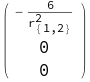
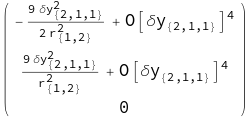
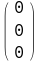
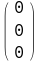
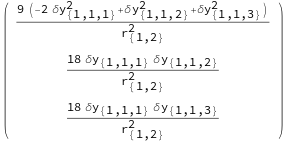
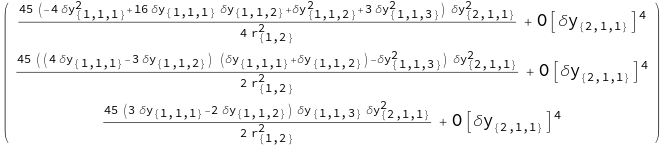
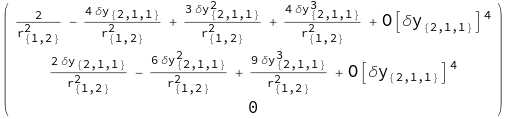
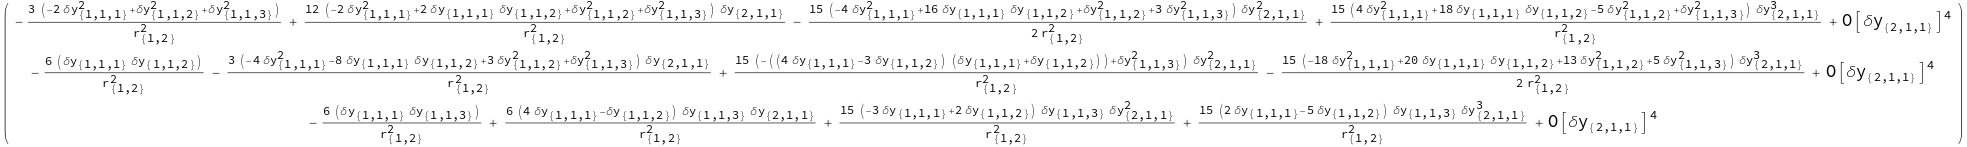
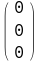
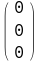
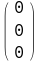
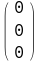
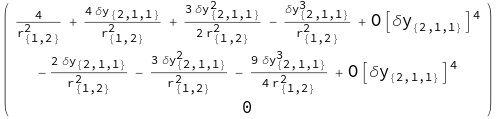
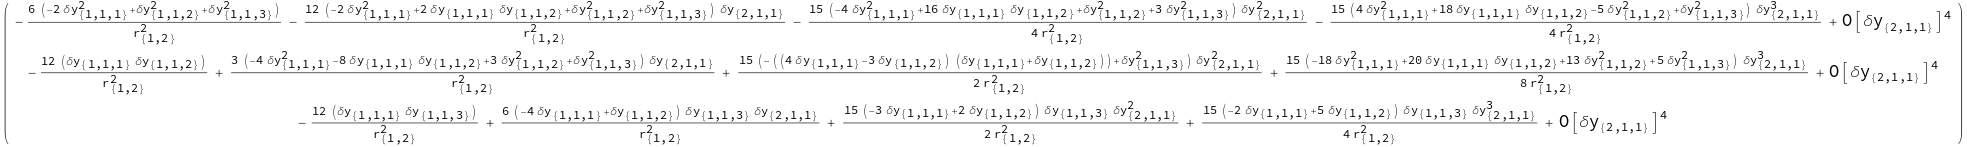
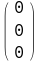
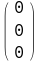
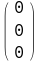
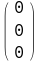

In [1001]:
YTaylorExpansion[force_] := ParallelMap[
  Series[#,
    Which[
      case == 1,
      {Subscript[\[Delta]y, {2, 1, 1}], 0, 3},
      case == 2,
      {Subscript[\[Delta]y, {2, 1, 2}], 0, 3},
      case == 3,
      {Subscript[\[Delta]y, {2, 1, 1}], 0, 3}
    ]
  ]
  &,
  ReplaceAll[
    force
    , yRules
  ]
]

YTaylorExpansion[fMPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[fQPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f2MPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 1, 2]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 1, 2]] // MatrixForm // FullSimplify
YTaylorExpansion[f3QPhantom[Np, 1, 2]] // MatrixForm // FullSimplify

YTaylorExpansion[fMPhantom[Np, 3, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[fQPhantom[Np, 3, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[f2MPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 3, 1]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 3, 1]] // MatrixForm

YTaylorExpansion[fMPhantom[Np, 4, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[fQPhantom[Np, 4, 1]] // MatrixForm // FullSimplify
YTaylorExpansion[f2MPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f2QPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f3MPhantom[Np, 4, 1]] // MatrixForm
YTaylorExpansion[f3QPhantom[Np, 4, 1]] // MatrixForm

2                                               2
(3 (4 + 60 δy           + 270 δy          δy          - 75 δy           + 
             {1, 1, 1}          {1, 1, 1}   {1, 1, 2}        {1, 1, 2}
 
                       2             3              2                  4
>        15 δy          ) δy          ) / (4 r       ) + O[δy         ]
              {1, 1, 3}     {2, 1, 1}         {1, 2}         {2, 1, 1}

                      2                                               2
(9 (6 + 90 δy           - 100 δy          δy          - 65 δy           - 
             {1, 1, 1}          {1, 1, 1}   {1, 1, 2}        {1, 1, 2}
 
                       2             3              2                  4
>        25 δy          ) δy          ) / (8 r       ) + O[δy         ]
              {1, 1, 3}     {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                          3
45 (2 δy          - 5 δy         ) δy          δy
        {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}                  4
----------------------------------------------------------- + O[δy         ]
                                 2                                {2, 1, 1}
                        4 r
                           {1, 2}
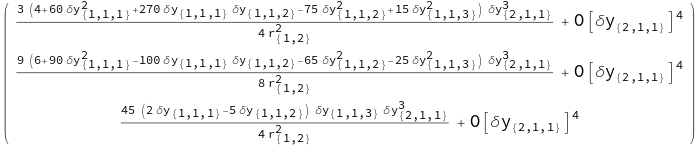

In [1023]:
fAFromB = (fMPhantom[Np, 1, 2] + fQPhantom[Np, 1, 2]
  + f2MPhantom[Np, 1, 2] + f2QPhantom[Np, 1, 2]
  + f3MPhantom[Np, 1, 2] + f3QPhantom[Np, 1, 2]);
fb1FromA = (fMPhantom[Np, 3, 1] + fQPhantom[Np, 3, 1]
  + f2MPhantom[Np, 3, 1] + f2QPhantom[Np, 3, 1]
  + f3MPhantom[Np, 3, 1] + f3QPhantom[Np, 3, 1]);
fb2FromA = (fMPhantom[Np, 4, 1] + fQPhantom[Np, 4, 1]
  + f2MPhantom[Np, 4, 1] + f2QPhantom[Np, 4, 1]
  + f3MPhantom[Np, 4, 1] + f3QPhantom[Np, 4, 1]);

F = YTaylorExpansion[fAFromB + fb1FromA + fb2FromA];
F = FullSimplify[F] // MatrixForm

#### There <span style="color:red">IS</span> additional force if the first node is collapsed into a dot

3
3 δy
    {2, 1, 1}                  4
-------------- + O[δy         ]
          2          {2, 1, 1}
   r
    {1, 2}

              3
27 δy
     {2, 1, 1}                  4
--------------- + O[δy         ]
           2          {2, 1, 1}
  4 r
     {1, 2}





              4
O[δy         ]
    {2, 1, 1}
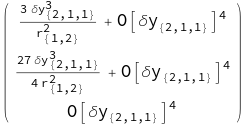

In [1024]:
FullSimplify[
  F,
  Flatten@Table[Subscript[\[Delta]y, {1, p, i}] == 0, {p, Np[[1]]}, {i, 3}]
]

2                3
9 δy             3 δy
    {2, 1, 1}        {2, 1, 1}                  4
-------------- + -------------- + O[δy         ]
           2               2          {2, 1, 1}
  2 r               r
     {1, 2}          {1, 2}

              2                 3
-9 δy             27 δy
     {2, 1, 1}         {2, 1, 1}                  4
--------------- + --------------- + O[δy         ]
          2                  2          {2, 1, 1}
   r                4 r
    {1, 2}             {1, 2}







0
0

0

0
                       2                                             2
(-9 (2 - 20 δy           + 80 δy          δy          + 5 δy           + 
              {1, 1, 1}         {1, 1, 1}   {1, 1, 2}       {1, 1, 2}
 
                       2             2              2
>        15 δy          ) δy          ) / (4 r       ) + 
              {1, 1, 3}     {2, 1, 1}         {1, 2}
 
                      2                                             2              2
>   (45 (4 δy           + 18 δy          δy          - 5 δy           + δy          ) 
             {1, 1, 1}         {1, 1, 1}   {1, 1, 2}       {1, 1, 2}      {1, 1, 3}
 
                  3              2                  4
>      δy          ) / (4 r       ) + O[δy         ]
         {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                                                     2
(9 (2 - 5 (4 δy          - 3 δy         ) (δy          + δy         ) + 5 δy          ) 
               {1, 1, 1}       {1, 1, 2}     {1, 1, 1}     {1, 1, 2}        {1, 1, 3}
 
                  2              2
>      δy          ) / (2 r       ) - 
         {2, 1, 1}         {1, 2}
 
                        2                                              2
>   (45 (-18 δy           + 20 δy          δy          + 13 δy           + 
               {1, 1, 1}         {1, 1, 1}   {1, 1, 2}        {1, 1, 2}
 
                      2             3              2                  4
>        5 δy          ) δy          ) / (8 r       ) + O[δy         ]
             {1, 1, 3}     {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                           2
45 (-3 δy          + 2 δy         ) δy          δy
         {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}
------------------------------------------------------------ + 
                                  2
                         2 r
                            {1, 2}
 
                                                              3
    45 (2 δy          - 5 δy         ) δy          δy
            {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}                  4
>   ----------------------------------------------------------- + O[δy         ]
                                     2                                {2, 1, 1}
                            4 r
                               {1, 2}
0

0

0
                   2                                           2                2
(45 (-4 δy           + 16 δy          δy          + δy           + 3 δy          ) 
          {1, 1, 1}         {1, 1, 1}   {1, 1, 2}     {1, 1, 2}        {1, 1, 3}
 
                  2              2                  4
>      δy          ) / (4 r       ) + O[δy         ]
         {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                                              2
(45 ((4 δy          - 3 δy         ) (δy          + δy         ) - δy          ) 
          {1, 1, 1}       {1, 1, 2}     {1, 1, 1}     {1, 1, 2}      {1, 1, 3}
 
                  2              2                  4
>      δy          ) / (2 r       ) + O[δy         ]
         {2, 1, 1}         {1, 2}         {2, 1, 1}

                                                          2
45 (3 δy          - 2 δy         ) δy          δy
        {1, 1, 1}       {1, 1, 2}    {1, 1, 3}   {2, 1, 1}                  4
----------------------------------------------------------- + O[δy         ]
            
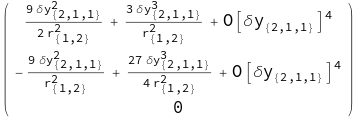
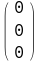
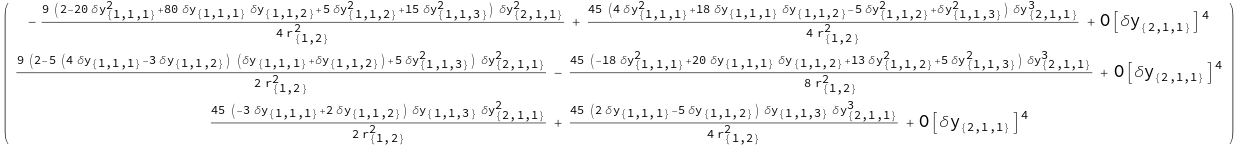
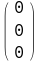
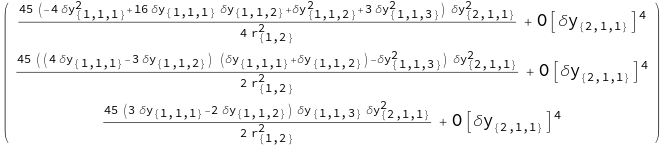
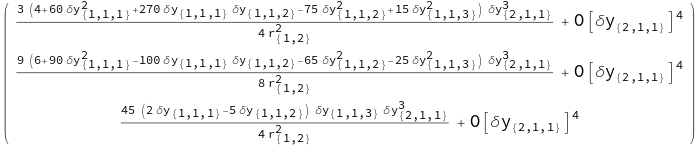

In [1026]:
fr2 = fMPhantom[Np, 1, 2] + fMPhantom[Np, 3, 1] + fMPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr2 // MatrixForm
fr3 = f2MPhantom[Np, 1, 2] + f2MPhantom[Np, 3, 1] + f2MPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr3 // MatrixForm
fr4 = fQPhantom[Np, 1, 2] + fQPhantom[Np, 3, 1] + fQPhantom[Np, 4, 1] + f3MPhantom[Np, 1, 2] + f3MPhantom[Np, 3, 1] + f3MPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr4 // MatrixForm
fr5 = f2QPhantom[Np, 1, 2] + f2QPhantom[Np, 3, 1] + f2QPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr5 // MatrixForm
fr6 = f3QPhantom[Np, 1, 2] + f3QPhantom[Np, 3, 1] + f3QPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr6 // MatrixForm

FullSimplify[fr2 + fr4 + fr6] // MatrixForm

### Conclusion: the main disbalance is dy^3 term

2                3
           9 δy             3 δy
   6           {2, 1, 1}        {2, 1, 1}                  4
-------- + -------------- + -------------- + O[δy         ]
       2              2               2          {2, 1, 1}
r            2 r               r
 {1, 2}         {1, 2}          {1, 2}

              2                 3
-9 δy             27 δy
     {2, 1, 1}         {2, 1, 1}                  4
--------------- + --------------- + O[δy         ]
          2                  2          {2, 1, 1}
   r                4 r
    {1, 2}             {1, 2}







0
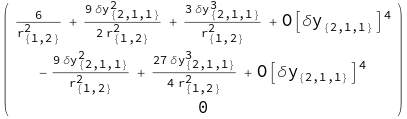

In [1037]:
fr = fMPhantom[Np, 3, 1] + fMPhantom[Np, 4, 1] // YTaylorExpansion // FullSimplify;
fr // MatrixForm

{1, 2, 1, 1}
              4
10 δy
     {2, 1, 1}
---------------
          2
   r
    {1, 2}
{1, 3, 2, 1}
              3
24 δy
     {2, 1, 1}
---------------
          2
   r
    {1, 2}
{1, 3, 1, 2}
              3
-3 δy
     {2, 1, 1}
---------------
          2
   r
    {1, 2}
{1, 2, 1, 1}
              4
15 δy
     {2, 1, 1}
---------------
           2
  4 r
     {1, 2}
{1, 3, 2, 1}
             3
9 δy
    {2, 1, 1}
--------------
          2
   r
    {1, 2}
{1, 3, 1, 2}
             3
9 δy
    {2, 1, 2}
--------------
           2
  8 r
     {1, 2}
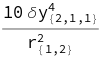
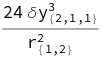
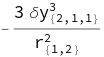
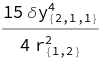
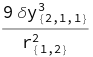
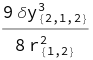

In [1039]:
(* case 1 *)
Np = {1, 2, 1, 1}
addForce = 10*Subscript[\[Delta]y, {2,1,1}]^4/Subscript[r, {1,2}]^2
Np = {1, 3, 2, 1}
addForce = 24*Subscript[\[Delta]y, {2,1,1}]^3/Subscript[r, {1,2}]^2
Np = {1, 3, 1, 2}
addForce = -3*Subscript[\[Delta]y, {2,1,1}]^3/Subscript[r, {1,2}]^2

(* case 2 *)
Np = {1, 2, 1, 1}
addForce = 15*Subscript[\[Delta]y, {2,1,1}]^4/(4*Subscript[r, {1,2}]^2)
Np = {1, 3, 2, 1}
addForce = 9*Subscript[\[Delta]y, {2,1,1}]^3/Subscript[r, {1,2}]^2
Np = {1, 3, 1, 2}
addForce = 9*Subscript[\[Delta]y, {2,1,2}]^3/(8*Subscript[r, {1,2}]^2)

### Let's do this using symbolic calculations

3
           M  (r + Δx )           Abs[M ]  (-(r M ) + M  Δx )
            1        1                 2         2     1   1
M  (-(----------------------) + --------------------------------)
 0              2      2 3/2                    2     2    2 3/2
      ((r + Δx )  + Δy  )       ((r M  - M  Δx )  + M   Δy  )
              1       1              2    1   1      1    1

                                                           3
                                                    Abs[M ]
                      2      2 -(3/2)                    2
M  M  Δy  (-((r + Δx )  + Δy  )       + --------------------------------)
 0  1   1           1       1                           2     2    2 3/2
                                        ((r M  - M  Δx )  + M   Δy  )
                                             2    1   1      1    1
                                        2
   M  (M  + M )    3 M  M  (M  + M ) Δy
    0   1    2        0  1   1    2    1          4
(-(------------) + ---------------------- + O[Δy ] ) + 
         2                   4                  1
        r                 2 r  M
                                2
 
             3        2     2
     6 M  (M   - M  M  ) Δy
        0   1     1  2     1          4
>   (------------------------ + O[Δy ] ) Δx  + 
               5   2                1      1
              r  M
                  2
 
                                      3     3     2
     -3 M  M  (M  + M )   15 M  M  (M   + M  ) Δy
         0  1   1    2        0  1   1     2     1          4     2
>   (------------------ + ------------------------- + O[Δy ] ) Δx   + 
            4                       6   3                 1      1
           r  M                    r  M
               2                       2
 
                    2
                  M
                   1
     4 M  M  (1 - ---)
        0  1        2             5        4     2
                  M      30 M  (M   - M  M  ) Δy
                   2         0   1     1  2     1          4     3         4
>   (----------------- + ------------------------- + O[Δy ] ) Δx   + O[Δx ]
             5                     7   4                 1      1        1
            r                     r  M
                                      2
                                    2     2     2               3     3     3
 3 M  M  (M  + M ) Δx    6 M  M  (M   - M  ) Δx     10 M  M  (M   + M  ) Δx
    0  1   1    2    1      0  1   1     2     1        0  1   1     2     1          4
(--------------------- + ------------------------ + ------------------------- + O[Δx ] ) 
          4                        5   2                      6   3                 1
         r  M                     r  M                       r  M
             2                        2                          2
 
                        2     2                3     3
            3 M  M  (-M   + M  )   15 M  M  (M   + M  ) Δx
               0  1    1     2         0  1   1     2     1
>    Δy  + (-------------------- - ------------------------ + 
       1             5   2                    6   3
                  2 r  M                   2 r  M
                        2                        2
 
                    4     4     2                5     5     3
       45 M  M  (-M   + M  ) Δx     105 M  M  (M   + M  ) Δx
           0  1    1     2     1         0  1   1     2     1          4     3         4
>      -------------------------- - -------------------------- + O[Δx ] ) Δy   + O[Δy ]
                   7   4                        8   5                1      1        1
                2 r  M                       2 r  M
                      2                            2
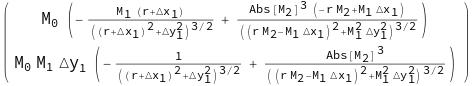
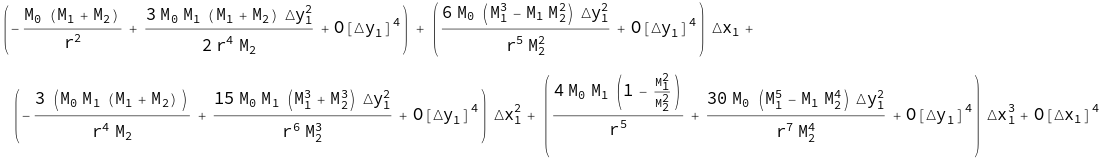
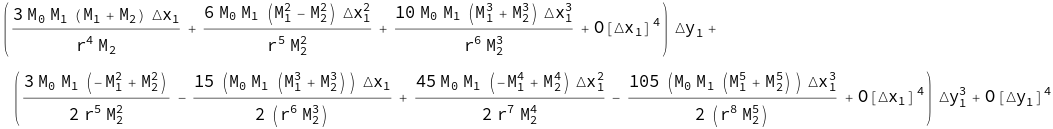

In [1066]:
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

M0 = Subscript[M,0];
M1 = Subscript[M,1];
M2 = Subscript[M,2];
dx1 = Subscript[\[CapitalDelta]x, 1];
dy1 = Subscript[\[CapitalDelta]y, 1];
dx2 = - dx1*M1/M2;
dy2 = - dy1*M1/M2;
r1 = {r + dx1, dy1};
r2 = {r + dx2, dy2};

$Assumptions = {
  _ \[Element] PositiveReals,
  r > 0,
  dx1 >= 0,
  dy1 >= 0
};

f1 = - M0*M1*r1/Norm[r1]^3;
f2 = - M0*M2*r2/Norm[r2]^3;

force = FullSimplify[f1 + f2];
force // MatrixForm

YTaylorExpansion[force_, da_, db_] := Module[
  {
    dfda,
    dfdb
  },
  dfda = Series[force,{da, 0, 3}];
  dfdb = Series[dfda,{db, 0, 3}]
  ;
  dfdb // FullSimplify // MatrixForm
]

YTaylorExpansion[force[[1]], dx1, dy1]
YTaylorExpansion[force[[2]], dy1, dx1]

3        2             6         4    2         2    4        6
Abs[M ] Abs[M   - M  M  ] Sqrt[64 Δx   - 48 Δx   Δy   + 72 Δx   Δy   + 9 Δy  ]
     0       1     1  2             1         1    1         1    1        1
------------------------------------------------------------------------------
                                      5   2
                                   2 r  M
                                         2
                    2
                  M
                   1       3
4 Abs[M  M  (-1 + ---)] Δx
       0  1         2     1
                  M
                   2
----------------------------
              5
             r
                3        2     3
3 Abs[M ] Abs[M   - M  M  ] Δy
       0       1     1  2     1
--------------------------------
               5   2
            2 r  M
                  2
                       3        2     3
Sqrt[97] Abs[M ] Abs[M   - M  M  ] Δx
              0       1     1  2     1
---------------------------------------
                  5   2
               2 r  M
                     2
                            6   2   2    2     2 2
                           s  M   M   (M   - M  )
                               0   1    1     2
             Sqrt[97] Sqrt[-----------------------]
                                    10   4
                                   r   M
                                        2
{Piecewise[{{--------------------------------------, 
                               2
 
>      (M  > 0 && M  > M  && M  > 0 && s > 0 && r > 0) || 
         2         1    2     0
 
>       (M  > 0 && 0 < M  < M  && M  > 0 && s > 0 && r > 0)}, 
          2             1    2     0
 
>     {0, M  > 0 && M  == M  && M  > 0 && s > 0 && r > 0}}, -Infinity], 
           2         1     2     0
 
                        s
>   {Δx  -> Piecewise[{{-, M  > 0 && M  == M  && M  > 0 && s > 0 && r > 0}, 
       1                2   2         1     2     0
 
>       {s, (M  > 0 && M  > M  && M  > 0 && s > 0 && r > 0) || 
              2         1    2     0
 
>         (M  > 0 && 0 < M  < M  && M  > 0 && s > 0 && r > 0)}}, Indeterminate], 
            2             1    2     0
 
                        s
>    Δy  -> Piecewise[{{-, M  > 0 && M  == M  && M  > 0 && s > 0 && r > 0}, 
       1                2   2         1     2     0
 
>       {s, (M  > 0 && M  > M  && M  > 0 && s > 0 && r > 0) || 
              2         1    2     0
 
>         (M  > 0 && 0 < M  < M  && M  > 0 && s > 0 && r > 0)}}, Indeterminate]}}
            2             1    2     0
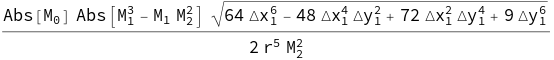
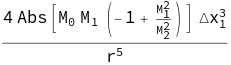
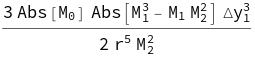
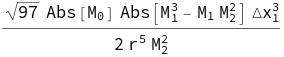
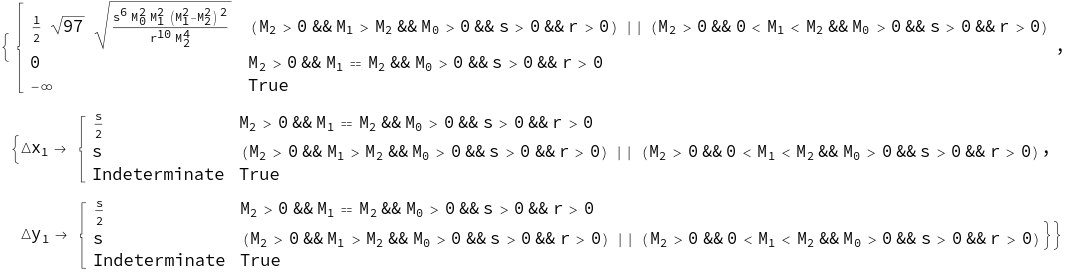

In [1073]:
fx[dx_, dy_] := M0*(6*M1*((M1/M2)^2 - 1)dx*dy^2/r^5 - 4*M1*((M1/M2)^2 - 1)*dx^3/r^5)
fy[dx_, dy_] := M0*(6*M1*((M1/M2)^2 - 1)dx^2*dy/r^5 - 3/2*M1*((M1/M2)^2 - 1)*dy^3/r^5)

fd[dx_, dy_] := Sqrt[fx[dx, dy]^2 + fy[dx, dy]^2]

FullSimplify[fd[dx1, dy1]]

(* e.g. *)
(* MassReplacer = {M1 -> 1, M2 -> 2, M0 -> 1} *)
(* case 1 *)
(* fd[dx1, 0] /. MassReplacer // FullSimplify *)
fd[dx1, 0] // FullSimplify
(* case 2 *)
(* fd[0, dy1] /. MassReplacer // FullSimplify *)
fd[0, dy1] // FullSimplify
(* case 3 *)
(* fd[dx1, dx1] /. MassReplacer // FullSimplify *)
fd[dx1, dx1] // FullSimplify

Maximize[
  {fd[dx1, dy1],
    0 <= dx1 <= s,
    0 <= dy1 <= s,
    M0 > 0,
    M1 > 0,
    M2 > 0,
    s > 0,
    r > 0
  },
  {dx1, dy1}
]

### Main Conclusion

3       3        2
Sqrt[97] Abs[s  M  (M   - M  M  )]
                 0   1     1  2
----------------------------------
                5   2
             2 r  M
                   2
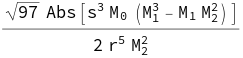

In [1086]:
fd[s, s] // FullSimplify

# The time of migration of the center of mass of the star to a distance equal to the radius of the star

2
456 Sqrt[97] Pi M
                 star
----------------------
           3      2
  5 Abs[N ]  R
         p    star
             2
2821.83 M
         star
---------------
       3      2
Abs[N ]  R
     p    star
    1/6  57 Pi 1/3      2   2
2 97    (-----)    M      N
           5        star   p
-----------------------------
              2/3        3
  n Abs[M    ]    Abs[N ]
         star          p
    1/6  57 Pi 1/3         2
2 97    (-----)    M     N
           5        star  p
----------------------------
              2/3        3
  n Abs[M    ]    Abs[N ]
         star          p
   2      2 3/2
(N   R     )
  p   star
---------------
       3      2
Abs[N ]  R
     p    star
   5   2/3   2      2
(-----)    N   R
 57 Pi      p   star
---------------------
    1/3           2/3
4 97    Abs[M    ]
             star
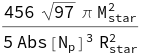
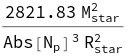
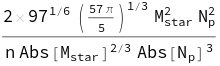
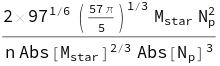
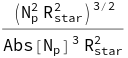
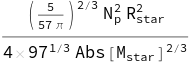

In [1112]:
hfact = Subscript[h,fact];
(* mass of the star *)
Ms = Subscript[M,star];
(* radius of the star *)
Rs = Subscript[R,star];
(* number of all particle in the star *)
Np = Subscript[N,p];
(* mass of the sph particle *)
mp = Ms/Np;
rho = Ms/(4/3*\[Pi]*Rs^3);
hp = hfact*(mp/rho)^(1/3);

(* Simplifications *)

(* number of all particle in the node *)
Npn = Subscript[N,pn];

(* number of particles in leaf node *)
Npn = 10;

(* The min size of the node is accepted as distance between sph particles *)
s = 2*hp/hfact;

(* masses of the nodes *)
M0 = Npn*mp;
(* difference is only 1 particle *)
M1 = (Npn - 1)*mp;
M2 = Npn*mp;

(* distance between nodes is equal to star radius *)
r = Rs;

Fadd = FullSimplify[fd[s, s]]
Fadd // N

impulse = Fadd*\[Tau]
(* assumes that all impulses are uniformly distributed in time *)
\[Tau] = T/n;
v = impulse/Ms
(* rcom = FullSimplify[Sqrt[1/3*v^2/\[Tau]^2*T^3]] *)
rcom = FullSimplify[Sqrt[v^2/\[Tau]^2*T^3]]

Tsol = Solve[rcom == Rs, {T}];
T = T/.Tsol[[1]]

2      2
0.00500779 N   R
            p   star
---------------------
           2/3
      M
       star
20031.2
          -6
3.52729 10
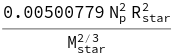

In [1122]:
T = FullSimplify[T, {Np > 0, Npn > 0, s > 0, Ms > 0}] // N

NumericalRules = {
  Subscript[h,fact] == 1.2,
  Subscript[R,star] == 10,
  Subscript[M,star] == 1,
  Subscript[N,p] == 200
  };

FullSimplify[T, NumericalRules]
FullSimplify[Fadd, NumericalRules]